<a href="https://colab.research.google.com/github/iryna-savchuk/DL_project/blob/catiaparrinha/3_1_model_handcrafted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

# Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Import Clean Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 3.024 seconds


# List of parameters

In [4]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create Train, validation and test datasets

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  # [Batch Size, H, W; C], first image, the first two pixels , of the very first channel
print("\nSample of y_train:", batch_y_train[0:5])  # the first 5 values form the vector
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  # reflects the balance of our target

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


# Augmentation

In [7]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")
# maybe we can explore different factors

In [8]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

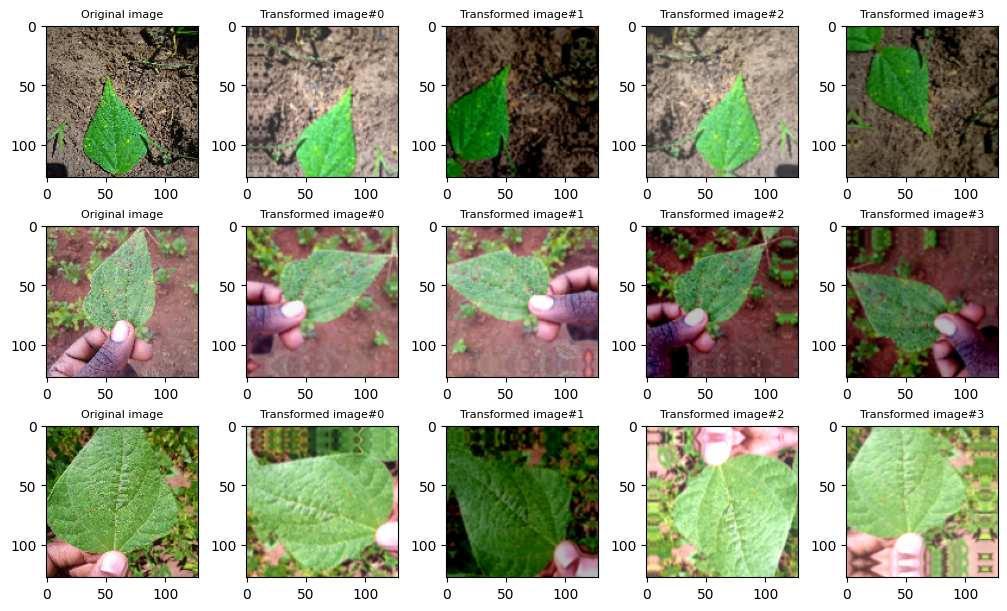

In [9]:
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)

# Architectures

In [10]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 128, 128, 3)

In [11]:
input_shape[1:]

(128, 128, 3)

## CNN 1 - Based in LeNet

In this architecture, we start with an input image. Then we apply a feature map(filter) with a kernel size (5,5) (we can try (7,7) or (3,3)) and an initializer GlorotNormal ().
We apply an activation function of softmax used to multi-class classification models. 
The image becomes ready for the pooling step, providing our convolutional neural network the extraction of the maximum value to account for distortion, providing the faculty of spatial invariance.
We repeat this process twice.
Then we flatten to get a pooled featured map that will be the input for our ANN.
This way, we apply the classification with three units, the dimensionality of our output space, with the softmax activation function. After defining our model, we configure how to conduct the learning process through the compile function. Our main parameters are a categorical cross-entropy for our loss function, an SGD(Stochastic Gradient Descent) with a learning rate of 0.001.
We will iterate the process 40 times using our training and validation dataset.

Model: "CNN-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                        

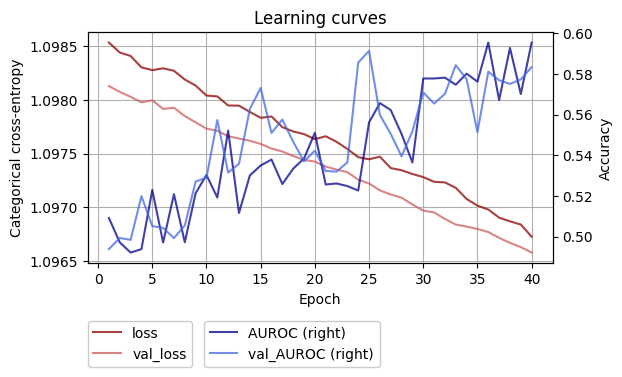

In [12]:
# Architecture V1
cnn1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1.build(input_shape)
# Check network
cnn1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

We need about 40 epoch to start to get more stable results, but even very instable. 

### CNN1.1
We will improve out basic model, with normalization, layers.Rescaling(1./255), similar to minmax, minimum value as 0 and maximum as 1, before we start the convolution process

Epoch 1/40
17/17 [==============================] - 4s 114ms/step - loss: 1.0989 - categorical_accuracy: 0.3298 - AUROC: 0.4973 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 2/40
17/17 [==============================] - 4s 185ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4794 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 3/40
17/17 [==============================] - 3s 103ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4866 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 4/40
17/17 [==============================] - 3s 102ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4953 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 5/40
17/17 [==============================] - 3s 125ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4981 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AURO

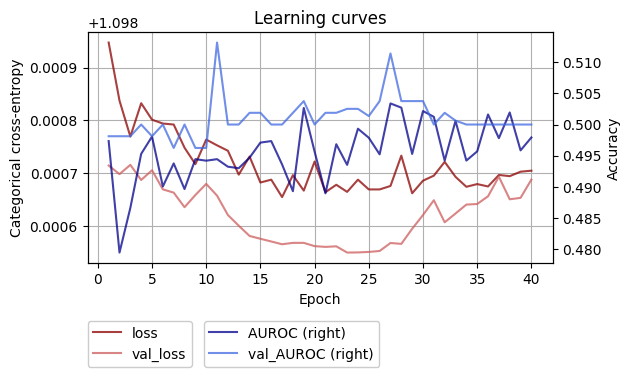

In [13]:
# Architecture V1.1
cnn1_1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V2)
epochs = 40
history1_1 = cnn1_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.3
Add normalization does not improve the model. The performance could be better, and it is precarious. Therefore, we will add the augmentation we prepared previously. 

Epoch 1/40
17/17 [==============================] - 5s 157ms/step - loss: 1.0989 - categorical_accuracy: 0.3298 - AUROC: 0.4973 - val_loss: 1.0988 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/40
17/17 [==============================] - 4s 111ms/step - loss: 1.0989 - categorical_accuracy: 0.3298 - AUROC: 0.4934 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 3/40
17/17 [==============================] - 3s 106ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4947 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 4/40
17/17 [==============================] - 3s 106ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4938 - val_loss: 1.0986 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 5/40
17/17 [==============================] - 3s 130ms/step - loss: 1.0987 - categorical_accuracy: 0.3298 - AUROC: 0.5000 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AURO

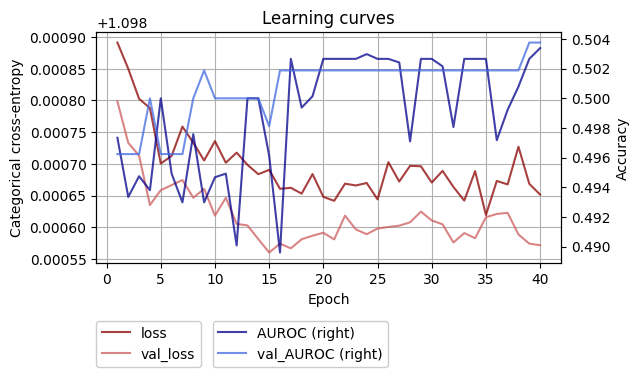

In [14]:
# Architecture V1.3
cnn1_3 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                    # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V3)
epochs = 40
history1_3 = cnn1_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

tf.get_logger().setLevel('ERROR')

### CNN1.4
As better results came from the first version, we will change the optimizer RMSprop to see if it improves

Epoch 1/40
17/17 [==============================] - 6s 112ms/step - loss: 1.3170 - categorical_accuracy: 0.3124 - AUROC: 0.4820 - val_loss: 1.4457 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 2/40
17/17 [==============================] - 3s 104ms/step - loss: 1.1800 - categorical_accuracy: 0.3269 - AUROC: 0.4996 - val_loss: 1.1356 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5025
Epoch 3/40
17/17 [==============================] - 3s 102ms/step - loss: 1.1782 - categorical_accuracy: 0.3559 - AUROC: 0.5105 - val_loss: 1.2302 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5031
Epoch 4/40
17/17 [==============================] - 5s 147ms/step - loss: 1.2291 - categorical_accuracy: 0.3066 - AUROC: 0.4795 - val_loss: 1.2505 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5032
Epoch 5/40
17/17 [==============================] - 3s 102ms/step - loss: 1.2015 - categorical_accuracy: 0.3366 - AUROC: 0.5070 - val_loss: 1.3184 - val_categorical_accuracy: 0.3308 - val_AURO

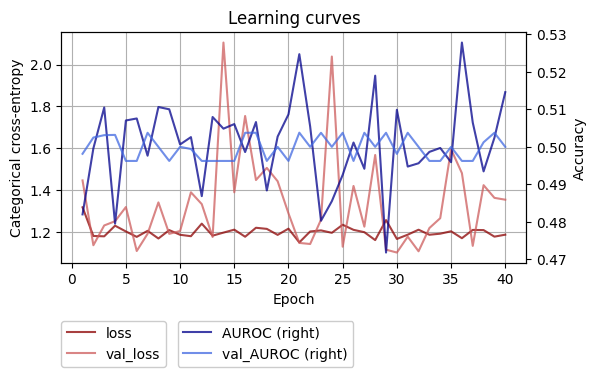

In [15]:
# Architecture V1.4
cnn1_4 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_4")


# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_4 = cnn1_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.5
As better results came from the first version, we will change the optimizer to Adam and see if it improves

Epoch 1/40
17/17 [==============================] - 5s 113ms/step - loss: 1.1402 - categorical_accuracy: 0.3337 - AUROC: 0.5143 - val_loss: 1.0985 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 2/40
17/17 [==============================] - 4s 129ms/step - loss: 1.1094 - categorical_accuracy: 0.3356 - AUROC: 0.4959 - val_loss: 1.0993 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5007
Epoch 3/40
17/17 [==============================] - 3s 102ms/step - loss: 1.1082 - categorical_accuracy: 0.3250 - AUROC: 0.4872 - val_loss: 1.1271 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5487
Epoch 4/40
17/17 [==============================] - 4s 157ms/step - loss: 1.1156 - categorical_accuracy: 0.3694 - AUROC: 0.5372 - val_loss: 1.1463 - val_categorical_accuracy: 0.3910 - val_AUROC: 0.5845
Epoch 5/40
17/17 [==============================] - 4s 178ms/step - loss: 0.9964 - categorical_accuracy: 0.5000 - AUROC: 0.6883 - val_loss: 0.9637 - val_categorical_accuracy: 0.4887 - val_AURO

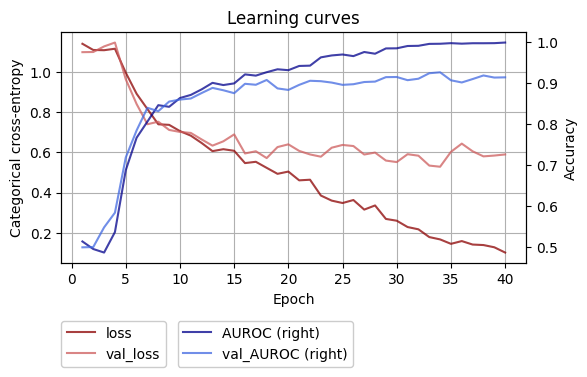

In [16]:
# Architecture V1.5
cnn1_5 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_5")


# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_5 = cnn1_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.6
Changing the optimizer to Adam improves the model, but after 15 epochs, the validation accuracy stabilizes, so we will add regularization L2 and decrease the epoch to 20.

Model: "CNN-V1.6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                      

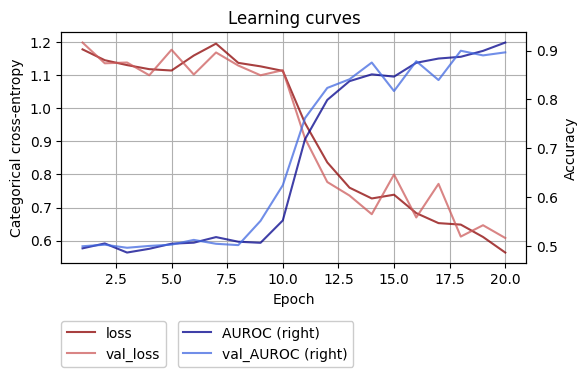

In [12]:
# Architecture V1.6
cnn1_6 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.6")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_6.build(input_shape)
# Check network
cnn1_6.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 20
history1_6 = cnn1_6.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

The LeNet model works very well with Adam optimizer. The main concern is overfitting, so we avoid implementing L2 regularization and stopping at the 20th epoch.

## CNN2 - AlexNet
Here we will aproach AlexNet method, by adding more layers (3 convolutional layers) and replacing the softmax in the convolution with the Relu that breaks up the linearity to increase the non-linearity of the images, employing the dropout rate regularization at starting point at 20%, to avoid overfitting and provide an efficient GPU implementation. We will strat with the same initial parameters, SGD optimizer, learning rate 0.001 and 40 epochs 

Epoch 1/40
17/17 [==============================] - 7s 196ms/step - loss: 1.1150 - categorical_accuracy: 0.3646 - AUROC: 0.5406 - val_loss: 1.0962 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5710
Epoch 2/40
17/17 [==============================] - 3s 100ms/step - loss: 1.0255 - categorical_accuracy: 0.5019 - AUROC: 0.6725 - val_loss: 1.0928 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5899
Epoch 3/40
17/17 [==============================] - 3s 100ms/step - loss: 0.9602 - categorical_accuracy: 0.5716 - AUROC: 0.7480 - val_loss: 1.0888 - val_categorical_accuracy: 0.5188 - val_AUROC: 0.6416
Epoch 4/40
17/17 [==============================] - 4s 157ms/step - loss: 0.9192 - categorical_accuracy: 0.6025 - AUROC: 0.7759 - val_loss: 1.0819 - val_categorical_accuracy: 0.3835 - val_AUROC: 0.6496
Epoch 5/40
17/17 [==============================] - 4s 99ms/step - loss: 0.8760 - categorical_accuracy: 0.6267 - AUROC: 0.7994 - val_loss: 1.0732 - val_categorical_accuracy: 0.5188 - val_AUROC

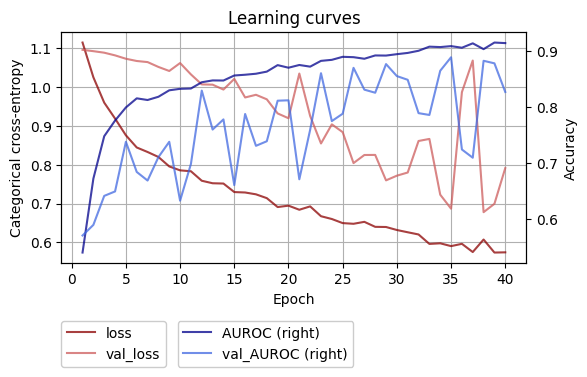

In [13]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2
cnn2 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.1
We got a volatile model. Then, we will try the Adam optimizer, which works well in the LeNet Model.

Epoch 1/40
17/17 [==============================] - 8s 110ms/step - loss: 2.8499 - categorical_accuracy: 0.3810 - AUROC: 0.5502 - val_loss: 1.0980 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5411
Epoch 2/40
17/17 [==============================] - 3s 99ms/step - loss: 0.9397 - categorical_accuracy: 0.5793 - AUROC: 0.7448 - val_loss: 1.0395 - val_categorical_accuracy: 0.3609 - val_AUROC: 0.6514
Epoch 3/40
17/17 [==============================] - 3s 99ms/step - loss: 0.8379 - categorical_accuracy: 0.6393 - AUROC: 0.8046 - val_loss: 1.0915 - val_categorical_accuracy: 0.3985 - val_AUROC: 0.5931
Epoch 4/40
17/17 [==============================] - 5s 168ms/step - loss: 0.7611 - categorical_accuracy: 0.6818 - AUROC: 0.8404 - val_loss: 1.1766 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6132
Epoch 5/40
17/17 [==============================] - 3s 105ms/step - loss: 0.6853 - categorical_accuracy: 0.7108 - AUROC: 0.8721 - val_loss: 1.3119 - val_categorical_accuracy: 0.3308 - val_AUROC:

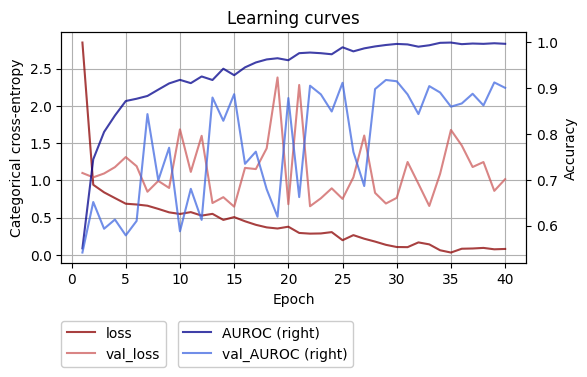

In [14]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.1
cnn2_1 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2_1 = cnn2_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.2
We will try with RMSprop Optimizer

Epoch 1/40
17/17 [==============================] - 5s 104ms/step - loss: 32.4489 - categorical_accuracy: 0.3723 - AUROC: 0.5289 - val_loss: 1.4216 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5207
Epoch 2/40
17/17 [==============================] - 3s 135ms/step - loss: 1.1499 - categorical_accuracy: 0.4536 - AUROC: 0.6181 - val_loss: 1.3227 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5488
Epoch 3/40
17/17 [==============================] - 4s 103ms/step - loss: 1.0598 - categorical_accuracy: 0.4691 - AUROC: 0.6523 - val_loss: 1.0835 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.6341
Epoch 4/40
17/17 [==============================] - 3s 96ms/step - loss: 1.0310 - categorical_accuracy: 0.5667 - AUROC: 0.7247 - val_loss: 1.0878 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5608
Epoch 5/40
17/17 [==============================] - 3s 98ms/step - loss: 0.9145 - categorical_accuracy: 0.6083 - AUROC: 0.7626 - val_loss: 1.1425 - val_categorical_accuracy: 0.3459 - val_AUROC

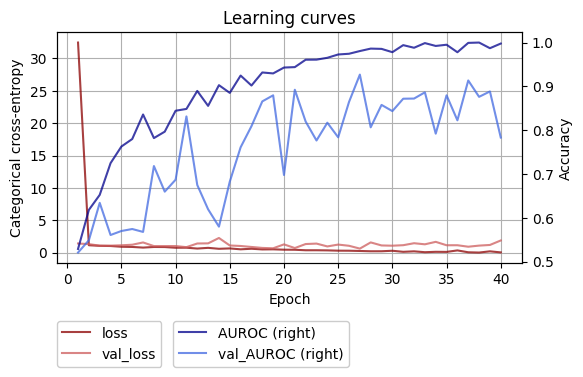

In [15]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.2
cnn2_2 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2_2 = cnn2_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.3
In the AlexNet method, the RMSprop Optimizer works better, but it can improve the unstable, we will increase the dropout rate to 30% and decrease the epoch to 30.

Epoch 1/30
17/17 [==============================] - 7s 107ms/step - loss: 32.4598 - categorical_accuracy: 0.3820 - AUROC: 0.5497 - val_loss: 1.0980 - val_categorical_accuracy: 0.3835 - val_AUROC: 0.5864
Epoch 2/30
17/17 [==============================] - 3s 122ms/step - loss: 1.0437 - categorical_accuracy: 0.5106 - AUROC: 0.6758 - val_loss: 1.0908 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6182
Epoch 3/30
17/17 [==============================] - 4s 196ms/step - loss: 1.1796 - categorical_accuracy: 0.5290 - AUROC: 0.6868 - val_loss: 1.0275 - val_categorical_accuracy: 0.5038 - val_AUROC: 0.6817
Epoch 4/30
17/17 [==============================] - 5s 168ms/step - loss: 0.9275 - categorical_accuracy: 0.5832 - AUROC: 0.7566 - val_loss: 1.3055 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5411
Epoch 5/30
17/17 [==============================] - 3s 99ms/step - loss: 1.0232 - categorical_accuracy: 0.5571 - AUROC: 0.7217 - val_loss: 0.9873 - val_categorical_accuracy: 0.4962 - val_AURO

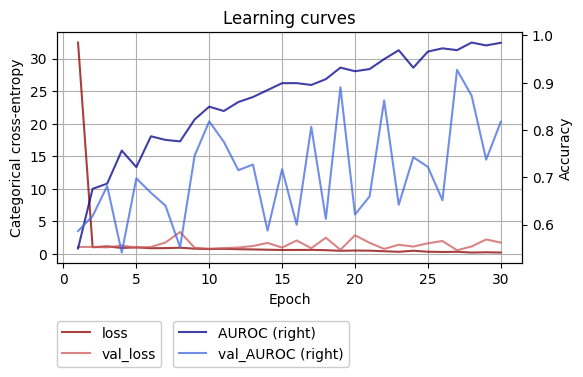

In [17]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V2.3
cnn2_3 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history2_3 = cnn2_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.4
Adding L2 Regularization

Epoch 1/30
17/17 [==============================] - 5s 107ms/step - loss: 14.9750 - categorical_accuracy: 0.3907 - AUROC: 0.5589 - val_loss: 1.1535 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5349
Epoch 2/30
17/17 [==============================] - 3s 98ms/step - loss: 1.1366 - categorical_accuracy: 0.4613 - AUROC: 0.6299 - val_loss: 1.1084 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5426
Epoch 3/30
17/17 [==============================] - 4s 155ms/step - loss: 1.0418 - categorical_accuracy: 0.4797 - AUROC: 0.6523 - val_loss: 1.0894 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5762
Epoch 4/30
17/17 [==============================] - 3s 98ms/step - loss: 1.1224 - categorical_accuracy: 0.4797 - AUROC: 0.6566 - val_loss: 1.1050 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5095
Epoch 5/30
17/17 [==============================] - 3s 99ms/step - loss: 1.0419 - categorical_accuracy: 0.5280 - AUROC: 0.6930 - val_loss: 1.0815 - val_categorical_accuracy: 0.4962 - val_AUROC:

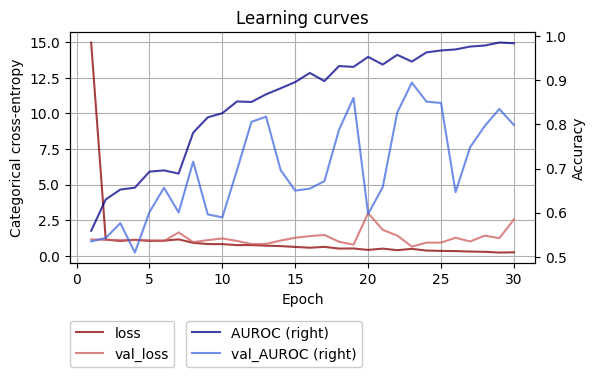

In [18]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V2.4
cnn2_4 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history2_4 = cnn2_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN3 - AlexNet simplified
Our model continue overfiting, we additional way to avoid it is to reduce the complexity of the model, we can do this by removing the last layer.

Epoch 1/30
17/17 [==============================] - 5s 109ms/step - loss: 5.7387 - categorical_accuracy: 0.4603 - AUROC: 0.6116 - val_loss: 1.1812 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5898
Epoch 2/30
17/17 [==============================] - 3s 114ms/step - loss: 0.9092 - categorical_accuracy: 0.5967 - AUROC: 0.7668 - val_loss: 1.0154 - val_categorical_accuracy: 0.4511 - val_AUROC: 0.6781
Epoch 3/30
17/17 [==============================] - 4s 125ms/step - loss: 0.9757 - categorical_accuracy: 0.5822 - AUROC: 0.7500 - val_loss: 1.1863 - val_categorical_accuracy: 0.3759 - val_AUROC: 0.5852
Epoch 4/30
17/17 [==============================] - 3s 95ms/step - loss: 0.8929 - categorical_accuracy: 0.5928 - AUROC: 0.7778 - val_loss: 1.2567 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5929
Epoch 5/30
17/17 [==============================] - 3s 94ms/step - loss: 0.8100 - categorical_accuracy: 0.6354 - AUROC: 0.8179 - val_loss: 0.9216 - val_categorical_accuracy: 0.5714 - val_AUROC:

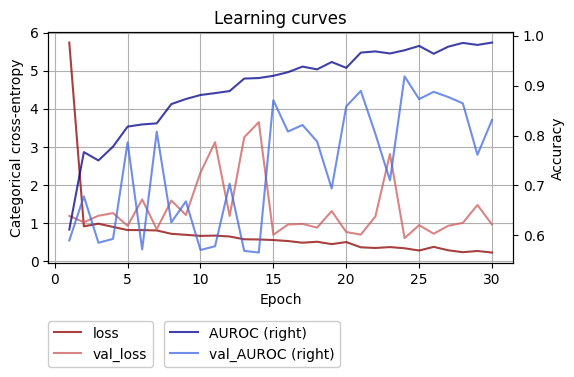

In [19]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3
cnn3 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.1
Replaces the ``Rescaling`` layer with ``BatchNormalization``, allows to computing the z-scores from the pixel values.

Epoch 1/30
17/17 [==============================] - 5s 101ms/step - loss: 5.0986 - categorical_accuracy: 0.4468 - AUROC: 0.5880 - val_loss: 9.3751 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4987
Epoch 2/30
17/17 [==============================] - 3s 96ms/step - loss: 1.0717 - categorical_accuracy: 0.5435 - AUROC: 0.7001 - val_loss: 4.6826 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5519
Epoch 3/30
17/17 [==============================] - 3s 96ms/step - loss: 0.9583 - categorical_accuracy: 0.5667 - AUROC: 0.7375 - val_loss: 1.2118 - val_categorical_accuracy: 0.4962 - val_AUROC: 0.6983
Epoch 4/30
17/17 [==============================] - 4s 176ms/step - loss: 0.8191 - categorical_accuracy: 0.6286 - AUROC: 0.8149 - val_loss: 6.2045 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.4888
Epoch 5/30
17/17 [==============================] - 3s 100ms/step - loss: 0.8509 - categorical_accuracy: 0.6286 - AUROC: 0.8037 - val_loss: 2.4226 - val_categorical_accuracy: 0.3910 - val_AUROC:

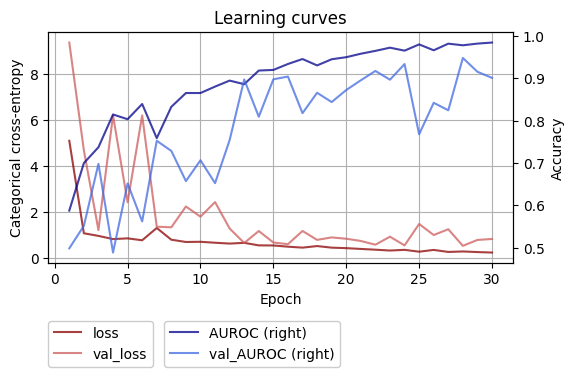

In [20]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.1
cnn3_1 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_1 = cnn3_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.2
Dropout rate 20%, delete regularization L2 and 20 epoch.

Epoch 1/20
17/17 [==============================] - 5s 137ms/step - loss: 6.0350 - categorical_accuracy: 0.4284 - AUROC: 0.5812 - val_loss: 13.6865 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 2/20
17/17 [==============================] - 3s 98ms/step - loss: 0.9595 - categorical_accuracy: 0.5667 - AUROC: 0.7373 - val_loss: 0.9722 - val_categorical_accuracy: 0.5564 - val_AUROC: 0.7586
Epoch 3/20
17/17 [==============================] - 3s 95ms/step - loss: 0.9559 - categorical_accuracy: 0.5793 - AUROC: 0.7517 - val_loss: 4.2149 - val_categorical_accuracy: 0.3985 - val_AUROC: 0.5716
Epoch 4/20
17/17 [==============================] - 3s 94ms/step - loss: 0.9965 - categorical_accuracy: 0.5851 - AUROC: 0.7527 - val_loss: 3.5107 - val_categorical_accuracy: 0.3910 - val_AUROC: 0.5797
Epoch 5/20
17/17 [==============================] - 3s 117ms/step - loss: 0.8203 - categorical_accuracy: 0.6412 - AUROC: 0.8152 - val_loss: 0.9629 - val_categorical_accuracy: 0.6541 - val_AUROC:

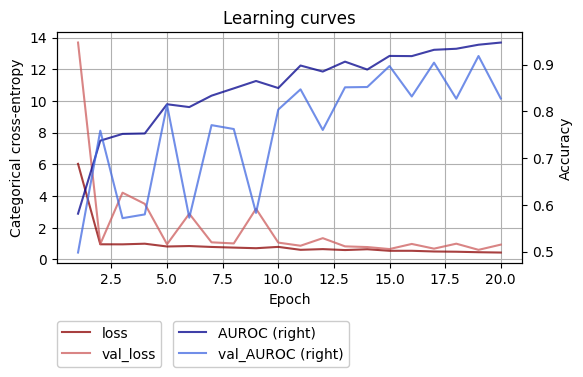

In [21]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V3.1
cnn3_2 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 20
history3_2 = cnn3_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.3
Adding Augmentation

Epoch 1/20
17/17 [==============================] - 8s 108ms/step - loss: 7.2121 - categorical_accuracy: 0.3723 - AUROC: 0.5317 - val_loss: 3.9579 - val_categorical_accuracy: 0.4962 - val_AUROC: 0.5820
Epoch 2/20
17/17 [==============================] - 5s 240ms/step - loss: 1.0689 - categorical_accuracy: 0.4429 - AUROC: 0.6273 - val_loss: 1.5459 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5108
Epoch 3/20
17/17 [==============================] - 3s 105ms/step - loss: 1.1095 - categorical_accuracy: 0.4749 - AUROC: 0.6410 - val_loss: 3.6617 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5726
Epoch 4/20
17/17 [==============================] - 4s 154ms/step - loss: 1.0322 - categorical_accuracy: 0.5426 - AUROC: 0.6945 - val_loss: 1.3428 - val_categorical_accuracy: 0.4511 - val_AUROC: 0.6945
Epoch 5/20
17/17 [==============================] - 3s 101ms/step - loss: 0.9879 - categorical_accuracy: 0.5493 - AUROC: 0.7171 - val_loss: 4.2022 - val_categorical_accuracy: 0.3459 - val_AURO

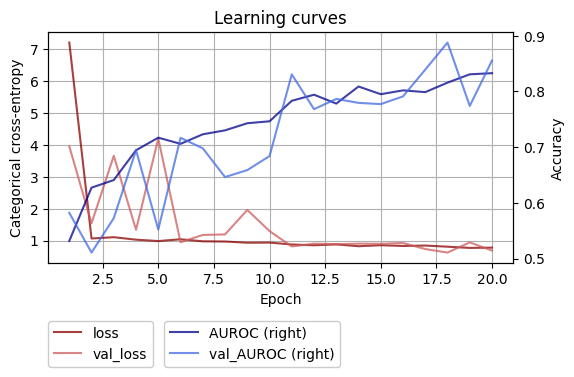

In [22]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V3.1
cnn3_3 = Sequential([# The input layer
                   layers.Input(input_shape),  
                   # Data augmentation
                   augmentation,   
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 20
history3_3 = cnn3_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.4
Augmentation, 20% dropout_rate, L2 regularization, 30 epochs

Epoch 1/30
17/17 [==============================] - 62s 3s/step - loss: 5.5103 - categorical_accuracy: 0.3433 - AUROC: 0.5187 - val_loss: 9.3539 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 2/30
17/17 [==============================] - 45s 3s/step - loss: 1.1248 - categorical_accuracy: 0.4487 - AUROC: 0.6105 - val_loss: 1.0243 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6780
Epoch 3/30
17/17 [==============================] - 45s 2s/step - loss: 1.0952 - categorical_accuracy: 0.4894 - AUROC: 0.6494 - val_loss: 1.4601 - val_categorical_accuracy: 0.3233 - val_AUROC: 0.5984
Epoch 4/30
17/17 [==============================] - 44s 2s/step - loss: 1.0174 - categorical_accuracy: 0.5445 - AUROC: 0.7009 - val_loss: 0.9811 - val_categorical_accuracy: 0.6015 - val_AUROC: 0.7467
Epoch 5/30
17/17 [==============================] - 46s 3s/step - loss: 0.9780 - categorical_accuracy: 0.5687 - AUROC: 0.7228 - val_loss: 1.5406 - val_categorical_accuracy: 0.3609 - val_AUROC: 0.6416


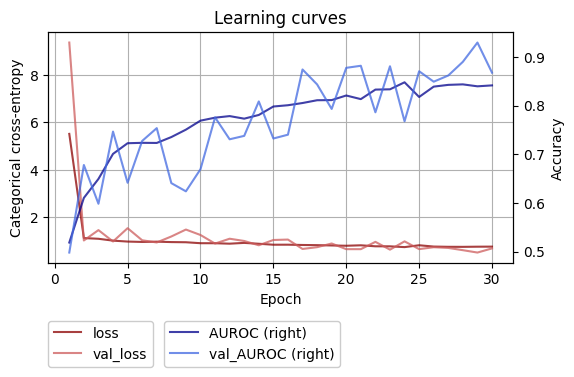

In [13]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.4
cnn3_4 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_4 = cnn3_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.5
Learning rate 0.0001

Epoch 1/30
17/17 [==============================] - 48s 3s/step - loss: 1.4374 - categorical_accuracy: 0.4333 - AUROC: 0.5980 - val_loss: 0.9432 - val_categorical_accuracy: 0.5414 - val_AUROC: 0.7478
Epoch 2/30
17/17 [==============================] - 44s 2s/step - loss: 1.0141 - categorical_accuracy: 0.5222 - AUROC: 0.7035 - val_loss: 1.1110 - val_categorical_accuracy: 0.4962 - val_AUROC: 0.6587
Epoch 3/30
17/17 [==============================] - 44s 2s/step - loss: 0.9516 - categorical_accuracy: 0.5464 - AUROC: 0.7319 - val_loss: 1.0579 - val_categorical_accuracy: 0.4286 - val_AUROC: 0.6686
Epoch 4/30
17/17 [==============================] - 44s 3s/step - loss: 0.9558 - categorical_accuracy: 0.5464 - AUROC: 0.7298 - val_loss: 1.0931 - val_categorical_accuracy: 0.3534 - val_AUROC: 0.6378
Epoch 5/30
17/17 [==============================] - 44s 2s/step - loss: 0.8977 - categorical_accuracy: 0.5870 - AUROC: 0.7709 - val_loss: 1.0818 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6325


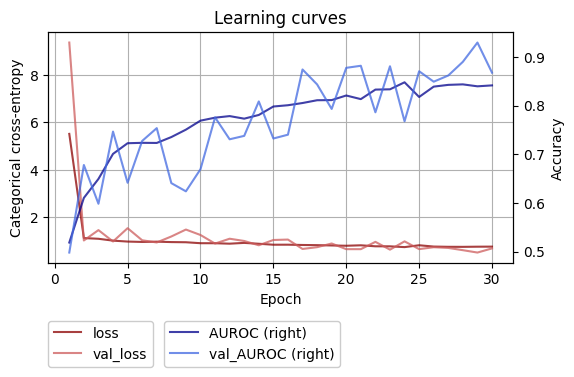

In [14]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.5
cnn3_5 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.5")

# Compiles the model for training.
learning_rate = 0.0001  
cnn3_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_5 = cnn3_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()